# BQRBM VS CRBM

In [2]:
import os

os.environ["QBM_PROJECT_DIR"] = str("annealing_proj")

In [3]:
%load_ext autoreload
%autoreload 2
#%load_ext autotime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.constants import k as k_B, h as h_P

k_B /= h_P * 1e9
matplotlib.rcParams.update({"font.size": 14})

from qbm.models import BQRBM
from qbm.utils import (
    Discretizer,
    kl_divergence,
    get_project_dir,
    get_rng,
    lr_exp_decay,
)

# configure directories
project_dir = get_project_dir()
example_dir = project_dir / "example"
models_dir = example_dir / "artifacts"
plots_dir = example_dir / "plots"
for dir_ in [example_dir, models_dir, plots_dir]:
    if not dir_.exists():
        dir_.mkdir(parents=True)

# load anneal schedule data
qpu_params = {"region": "na-west-1", "solver": "Advantage_system4.1"}
# the anneal schedules xlsx files can be found here:
# https://docs.dwavesys.com/docs/latest/doc_physical_properties.html#anneal-schedules
# from the xlsx file, save the processor-annealing-schedule sheet as a csv
csv_name = "09-1263A-A_Advantage_system4_1_annealing_schedule.csv"
df_anneal = pd.read_csv(
    project_dir / f"data/anneal_schedules/csv/{csv_name}", index_col="s",
)
if 0.5 not in df_anneal.index:
    df_anneal.loc[0.5] = (df_anneal.loc[0.499] + df_anneal.loc[0.501]) / 2
df_anneal.sort_index(inplace=True)

## Train Data Creation

In [4]:
seed = 42
n_visible = 8
n_hidden = 4
n_qubits = n_visible + n_hidden

rng = get_rng(seed)
n_samples = 1500
α = 2 / 3
N_1 = rng.normal(-2, 1, int(round(n_samples * α, 0)))
N_2 = rng.normal(3, 1, int(round(n_samples * (1 - α), 0)))
x = np.concatenate((N_1, N_2))

df = pd.DataFrame.from_dict({"x": x})
discretizer = Discretizer(df, n_bits=n_visible)
V_train = discretizer.df_to_bit_array(df)
V_train

array([[0, 1, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 1, 1]])

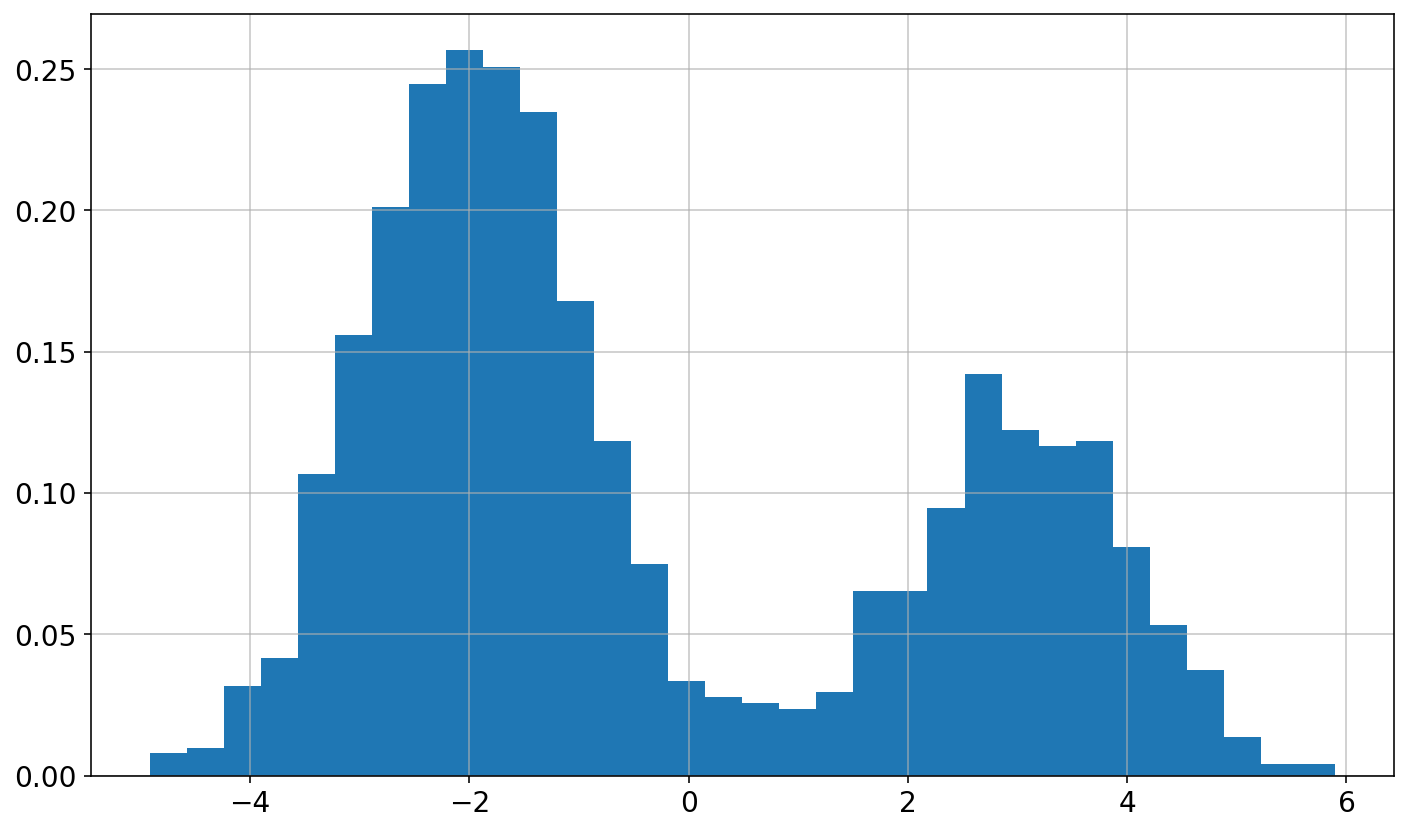

In [5]:
data = discretizer.undiscretize_df(discretizer.discretize_df(df))

n_bins = 32
fig, ax = plt.subplots(dpi=144, figsize=(10, 6))
_, bins, _ = ax.hist(data, bins=n_bins, density=True, label="Data")
ax.grid(alpha=0.7)
plt.tight_layout()
plt.savefig(plots_dir / "histogram_train.pdf")

In [6]:
import time
import numpy as np

def make_callback():
    epoch_times = []
    errors = []
    last_time = time.time()

    def compute_reconstruction_error(model, V_train):
        """
        Compute reconstruction error (MSE) for V_train.
        Assumes model has W (weights), b (biases), and V_train is binary or continuous.
        """
        # Split biases: visible (first n_visible), hidden (rest)
        n_visible = V_train.shape[1]
        vbias = model.b[:n_visible]
        hbias = model.b[n_visible:]

        # Compute hidden probabilities: P(h|v) = sigmoid(W^T v + hbias)
        hidden_activations = np.dot(V_train, model.W) + hbias
        hidden_probs = 1 / (1 + np.exp(-hidden_activations))
        # Sample hidden units
        hidden_states = (hidden_probs > np.random.random(hidden_probs.shape)).astype(np.float32)

        # Reconstruct visible units: P(v|h) = sigmoid(W h + vbias)
        visible_activations = np.dot(hidden_states, model.W.T) + vbias
        visible_probs = 1 / (1 + np.exp(-visible_activations))

        # Compute MSE between V_train and reconstructed visible_probs
        mse = np.mean(np.sum((V_train - visible_probs) ** 2, axis=1))
        return mse

    def callback(model, sample_state_vectors):
        nonlocal last_time

        # Timing
        now = time.time()
        epoch_times.append(now - last_time)
        last_time = now

        # Reconstruction error
        error = compute_reconstruction_error(model, model.V_train)
        errors.append(error)

        # Encode states as integers 0…2ⁿ-1
        n_vis = model.V_train.shape[1]
        weights = 2 ** np.arange(n_vis-1, -1, -1)

        train_bits = model._eigen_to_binary(model.V_train)
        train_ids = (train_bits * weights).sum(axis=1).astype(int)

        samp_bits = model._eigen_to_binary(sample_state_vectors[:, :n_vis])
        samp_ids = (samp_bits * weights).sum(axis=1).astype(int)

        # KL via bincount
        max_id = max(train_ids.max(), samp_ids.max())
        p_cnt = np.bincount(train_ids, minlength=max_id+1)
        q_cnt = np.bincount(samp_ids, minlength=max_id+1)
        p = p_cnt / p_cnt.sum()
        q = q_cnt / q_cnt.sum()
        mask = (p > 0) & (q > 0)
        dkl = np.sum(p[mask] * np.log(p[mask] / q[mask]))

        print(f"Epoch time: {epoch_times[-1]:.3f}s | D_KL = {dkl:.3f} | Error = {error:.4f}")
        return {"value": dkl, "epoch_time": epoch_times[-1], "error": error}

    callback.epoch_times = epoch_times
    callback.errors = errors
    return callback

## Simulation-based Model

In [7]:
import time
train_model = True
model_path = models_dir / "model_simulation.pkl"
if train_model:
    # model params
    s_freeze = 1.0
    embedding = None
    beta_initial = 1
    simulation_params = {"beta": 0.5}

    # training params
    n_epochs = 100
    n_samples = 10_000
    learning_rate = 0.1
    mini_batch_size = 10
    decay_epoch = 50
    decay_period = 10
    epochs = np.arange(1, n_epochs + 1)
    learning_rates = learning_rate * lr_exp_decay(epochs, decay_epoch=50, period=10)
    learning_rates_beta = learning_rate * lr_exp_decay(
        epochs, decay_epoch=50, period=20
    )

    # model init
    model_simulation = BQRBM(
        V_train=V_train,
        n_hidden=n_hidden,
        A_freeze=df_anneal.loc[s_freeze, "A(s) (GHz)"],
        B_freeze=df_anneal.loc[s_freeze, "B(s) (GHz)"],
        beta_initial=beta_initial,
        simulation_params=simulation_params,
    )

    start_time = time.time()
    callbackk = make_callback()
   

    # model train and save
    model_simulation.train(
        n_epochs=n_epochs,
        n_samples=n_samples,
        learning_rate=learning_rates,
        learning_rate_beta=learning_rates_beta,
        mini_batch_size=mini_batch_size,
        callback=callbackk,
    )
    model_simulation.save(model_path)
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")
    

else:
    model_simulation = BQRBM.load(model_path)

Epoch time: 3.733s | D_KL = 0.379 | Error = 9.6928
[BQRBM] epoch 1: β = 0.939, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:03.734926
Epoch time: 3.140s | D_KL = 0.279 | Error = 9.5494
[BQRBM] epoch 2: β = 0.848, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:03.139458
Epoch time: 2.633s | D_KL = 0.197 | Error = 9.4287
[BQRBM] epoch 3: β = 0.762, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.631947
Epoch time: 2.850s | D_KL = 0.148 | Error = 9.3386
[BQRBM] epoch 4: β = 0.709, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.851181
Epoch time: 2.929s | D_KL = 0.157 | Error = 9.3083
[BQRBM] epoch 5: β = 0.671, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.927535
Epoch time: 2.390s | D_KL = 0.158 | Error = 9.3256
[BQRBM] epoch 6: β = 0.644, learning rate = 1.00e-01, β learning rate = 1.00e-01, epoch duration = 0:00:02.391335
Epoch time

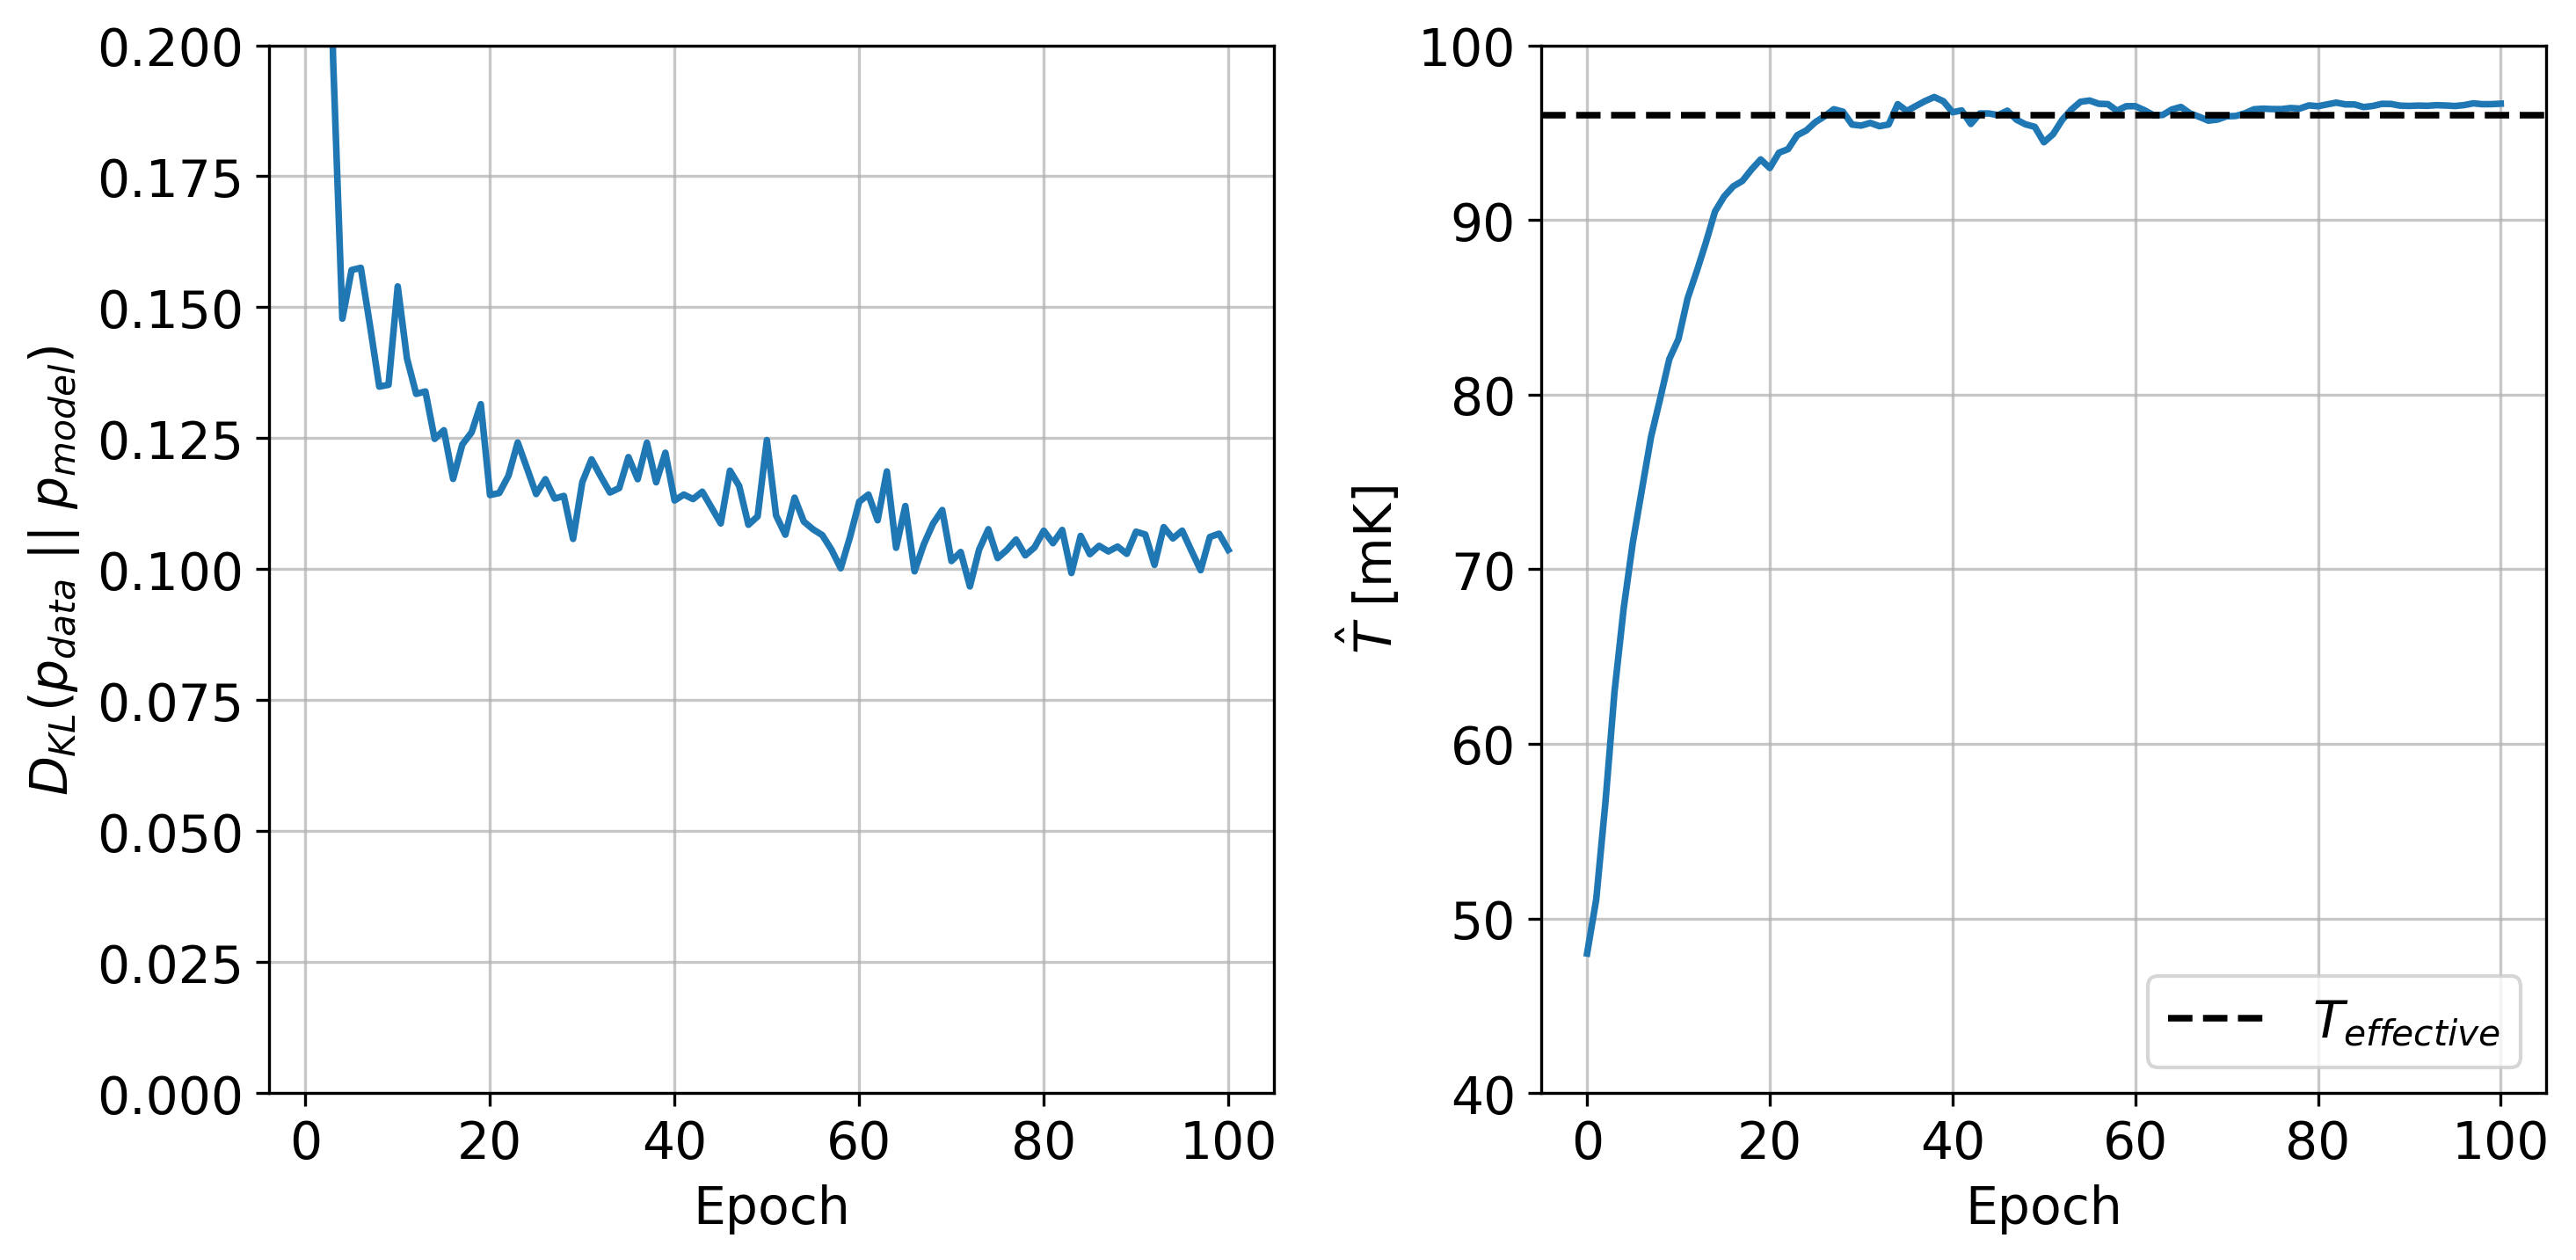

In [8]:

dkls = [x["value"] for x in model_simulation.callback_history]
epochs = np.arange(1, len(dkls) + 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax[0].plot(epochs, dkls, linewidth=1.8)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel(r"$D_{KL}(p_{data} \ || \ p_{model})$")
ax[0].set_yticks(np.arange(0, 22.5, 2.5) / 100)
ax[1].set_yticks(np.arange(40, 110, 10))
ax[0].set_ylim((0, 0.2))
ax[1].set_ylim((40, 100))
ax[0].grid(alpha=0.7)

ax[1].plot(
    range(len(model_simulation.beta_history)),
    1 / k_B / np.array(model_simulation.beta_history) * 1000,
    linewidth=1.8,
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel(r"$\hat{T}$ [mK]")
ax[1].axhline(
    1 / k_B / 0.5 * 1000,
    color="k",
    linestyle="--",
    label=r"$T_{effective}$",
    linewidth=1.8,
)
ax[1].grid(alpha=0.7)
ax[1].legend(loc="lower right")
plt.tight_layout()

plt.savefig(plots_dir / "train_results_simulation.pdf")

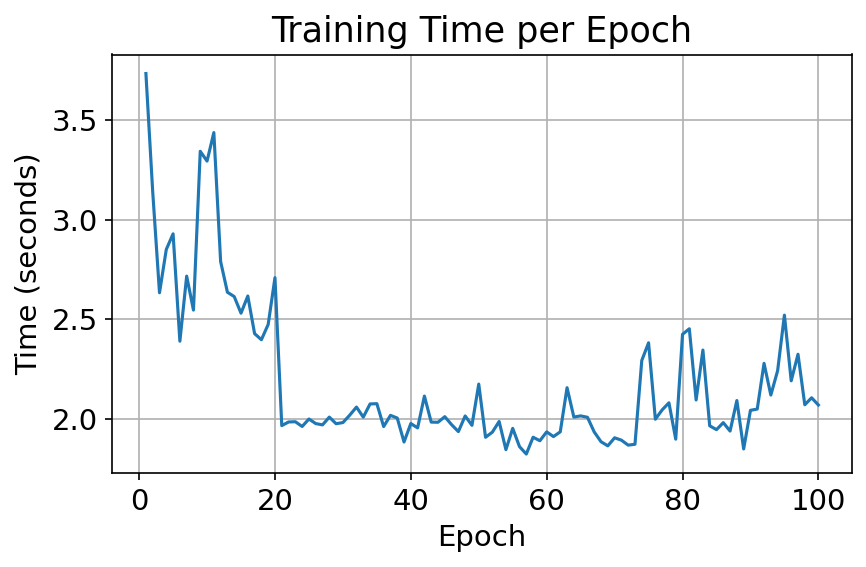

In [9]:
epoch_times = callbackk.epoch_times
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(range(1, len(epoch_times) + 1), epoch_times)
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.title("Training Time per Epoch")
plt.grid(True)
plt.tight_layout()
plt.savefig(plots_dir / "epoch_times_mnist.pdf")
plt.show()

# CRBM Training

In [10]:
def get_batches(data, batch_size, shuffle=False):
    N = data.shape[0]
    if batch_size == -1:
        batch_size = N
    if shuffle:
        indices = np.random.permutation(N)
    else:
        indices = np.arange(N)
    for start in range(0, N, batch_size):
        yield data[indices[start:start + batch_size]]

In [11]:
batch_size = 50
num_epochs = 100
lr = 0.1
burn_in = 0
num_steps = 1

In [12]:
from crbm.rbm import CRBM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
model = CRBM(v_dim=V_train.shape[-1], h_dim=4)

In [13]:
from time import time

# Training loop
errors = []
kl_divs_history = []
free_energies_val = []
free_energies_train = []
crbm_epoch_times = []  
start_time = time()
V_train2 = V_train.astype(np.float32)
weights = 2 ** np.arange(n_visible - 1, -1, -1)
n_visible = V_train.shape[-1]

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time()  
    iteration = 0
    error = 0
    for batch in get_batches(V_train, batch_size, shuffle=True):
        iteration += 1
        # Compute gradients and errors
        error += model.compute_grad(batch.astype(np.float32))        
        # Update parameters - use momentum as explained in Hinton's guide
        if epoch > 5:
            model.update(lr, momentum=0.5)
        else:
            model.update(lr, momentum=0.9)

    # Generate 1500 samples using original sample function
    n_samples = 1500
    sampled = np.zeros((n_samples, model.v_dim), dtype=np.float32)
    for i in range(n_samples):
        sampled[i] = model.sample(num_iters=100)
        
    # Convert to binary (0/1)
    train_bits = V_train2.astype(int)
    sampled_bits = sampled.astype(int)
    
    # Calculate state IDs
    train_ids = np.dot(train_bits, weights)
    sampled_ids = np.dot(sampled_bits, weights)
    
    # Compute histograms
    max_id = max(train_ids.max(), sampled_ids.max())
    p_counts = np.bincount(train_ids, minlength=max_id + 1)
    q_counts = np.bincount(sampled_ids, minlength=max_id + 1)
    
    # Normalize to probabilities
    p = p_counts / p_counts.sum()
    q = q_counts / q_counts.sum()
    
    # Compute DKL with epsilon to avoid division by zero
    epsilon = 1e-8
    mask = (p > epsilon) & (q > epsilon)
    dkl = np.sum(p[mask] * np.log(p[mask] / q[mask]))
    kl_divs_history.append(dkl)

        
    print("epoch:{} \t error:{:.4f} \t training time:{:.2f} s \t AVG DKL:{:.4f}".format(epoch, error, time() - start_time, dkl))
    errors.append(error)
    crbm_epoch_times.append( time() - epoch_start_time)


epoch:1 	 error:59.7105 	 training time:4.25 s 	 AVG DKL:0.5059
epoch:2 	 error:59.2318 	 training time:8.70 s 	 AVG DKL:0.4671
epoch:3 	 error:59.1340 	 training time:12.88 s 	 AVG DKL:0.4201
epoch:4 	 error:59.1664 	 training time:18.13 s 	 AVG DKL:0.4617
epoch:5 	 error:59.1369 	 training time:22.62 s 	 AVG DKL:0.4595
epoch:6 	 error:59.1344 	 training time:27.65 s 	 AVG DKL:0.4412
epoch:7 	 error:59.1343 	 training time:32.97 s 	 AVG DKL:0.4949
epoch:8 	 error:59.1447 	 training time:37.43 s 	 AVG DKL:0.4309
epoch:9 	 error:59.1229 	 training time:41.94 s 	 AVG DKL:0.4736
epoch:10 	 error:59.1338 	 training time:46.77 s 	 AVG DKL:0.3786
epoch:11 	 error:59.1376 	 training time:52.01 s 	 AVG DKL:0.4235
epoch:12 	 error:59.1257 	 training time:57.63 s 	 AVG DKL:0.4458
epoch:13 	 error:59.1689 	 training time:62.12 s 	 AVG DKL:0.4784
epoch:14 	 error:59.1496 	 training time:66.28 s 	 AVG DKL:0.4721
epoch:15 	 error:59.1399 	 training time:70.30 s 	 AVG DKL:0.4466
epoch:16 	 error:59.1


Total Training Time: 496.86 seconds
Average Time per Epoch: 4.97 seconds


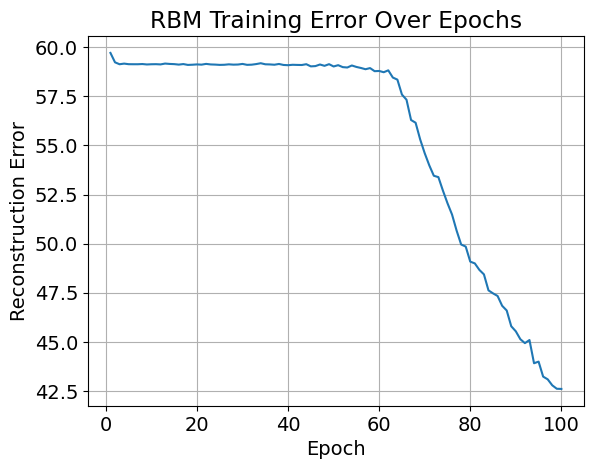

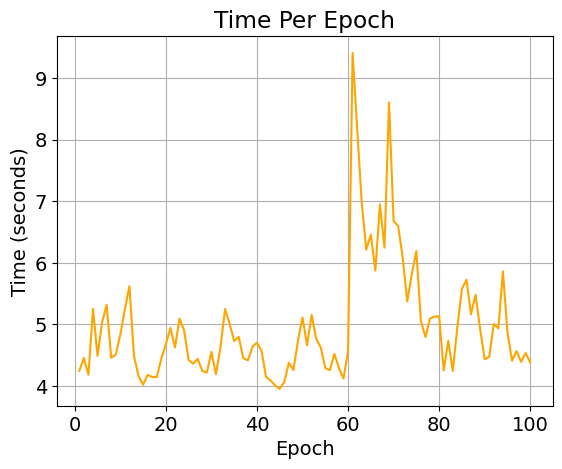

In [14]:
#  Plot Error Over Epochs 
plt.figure()

plt.plot(range(1, num_epochs + 1), errors)#, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.title("RBM Training Error Over Epochs")
plt.grid(True)
plt.savefig("error_plot.pdf")


#  Plot Training Time Per Epoch 
plt.figure()
plt.plot(range(1, num_epochs + 1), crbm_epoch_times, color='orange')
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.title("Time Per Epoch")
plt.grid(True)
plt.savefig("epoch_time_plot.pdf")


total_time = sum(crbm_epoch_times)
avg_time = total_time / num_epochs
print(f"\nTotal Training Time: {total_time:.2f} seconds")
print(f"Average Time per Epoch: {avg_time:.2f} seconds")


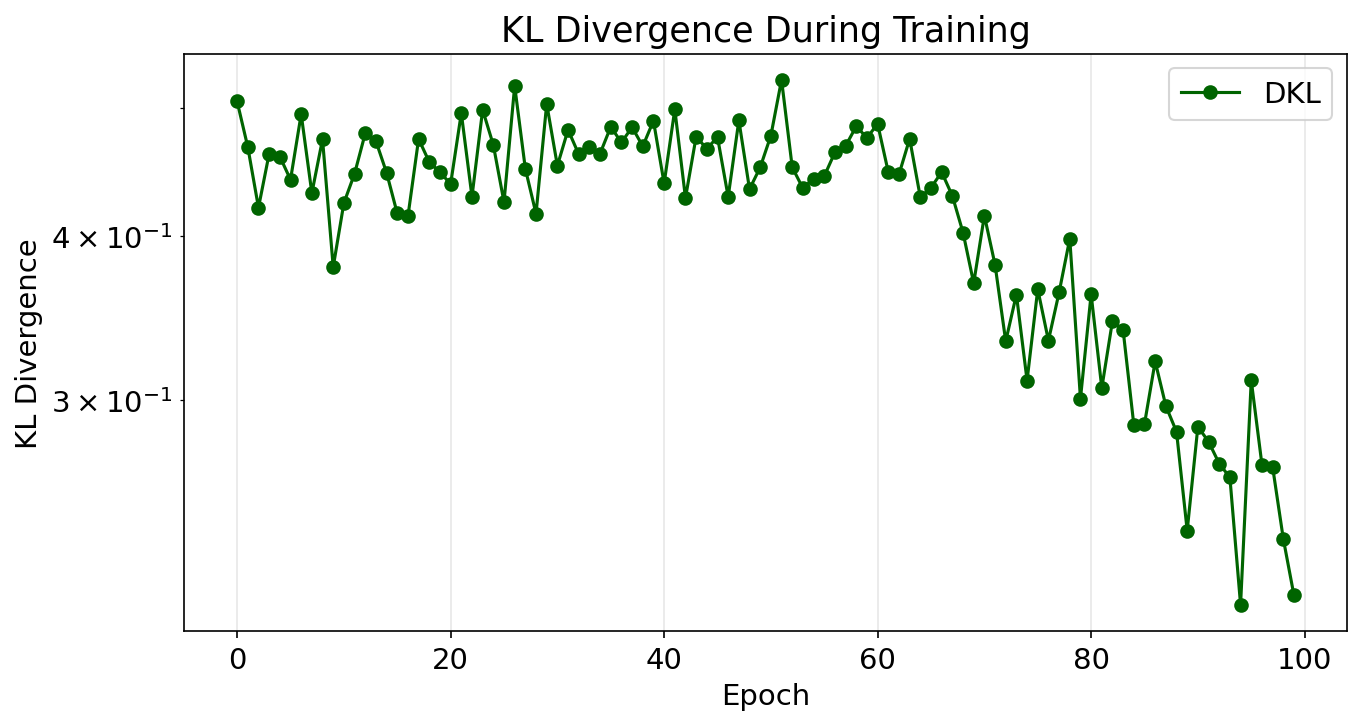

In [15]:
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(kl_divs_history, 'o-', color='darkgreen', label='DKL')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.title('KL Divergence During Training')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.legend()
plt.savefig('dkl_progress.pdf', bbox_inches='tight')
plt.show()

# COMPARAISON PLOTS

i didnt have any need to plot with np.log()

In [16]:
pip install SciencePlots

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

In [18]:
compare_dir = Path("compare_CRBM_QRBM")
compare_dir.mkdir(exist_ok=True)

# Data from BQRBM
bqrbm_dkls = dkls  
bqrbm_epochs = np.arange(1, len(bqrbm_dkls) + 1)
bqrbm_epoch_times = callbackk.epoch_times  
bqrbm_errors = callbackk.errors

# Data from CRBM
crbm_errors = errors
crbm_kl_divs_history = kl_divs_history
crbm_epochs = np.arange(1, len(crbm_kl_divs_history) + 1)

LookupError: An associated PostScript font (required by Matplotlib) could not be found for TeX font 'zptmcm7y' in 'C:/Users/user/AppData/Local/MiKTeX/fonts/map/pdftex/pdftex.map'; this problem can often be solved by installing a suitable PostScript font package in your TeX package manager

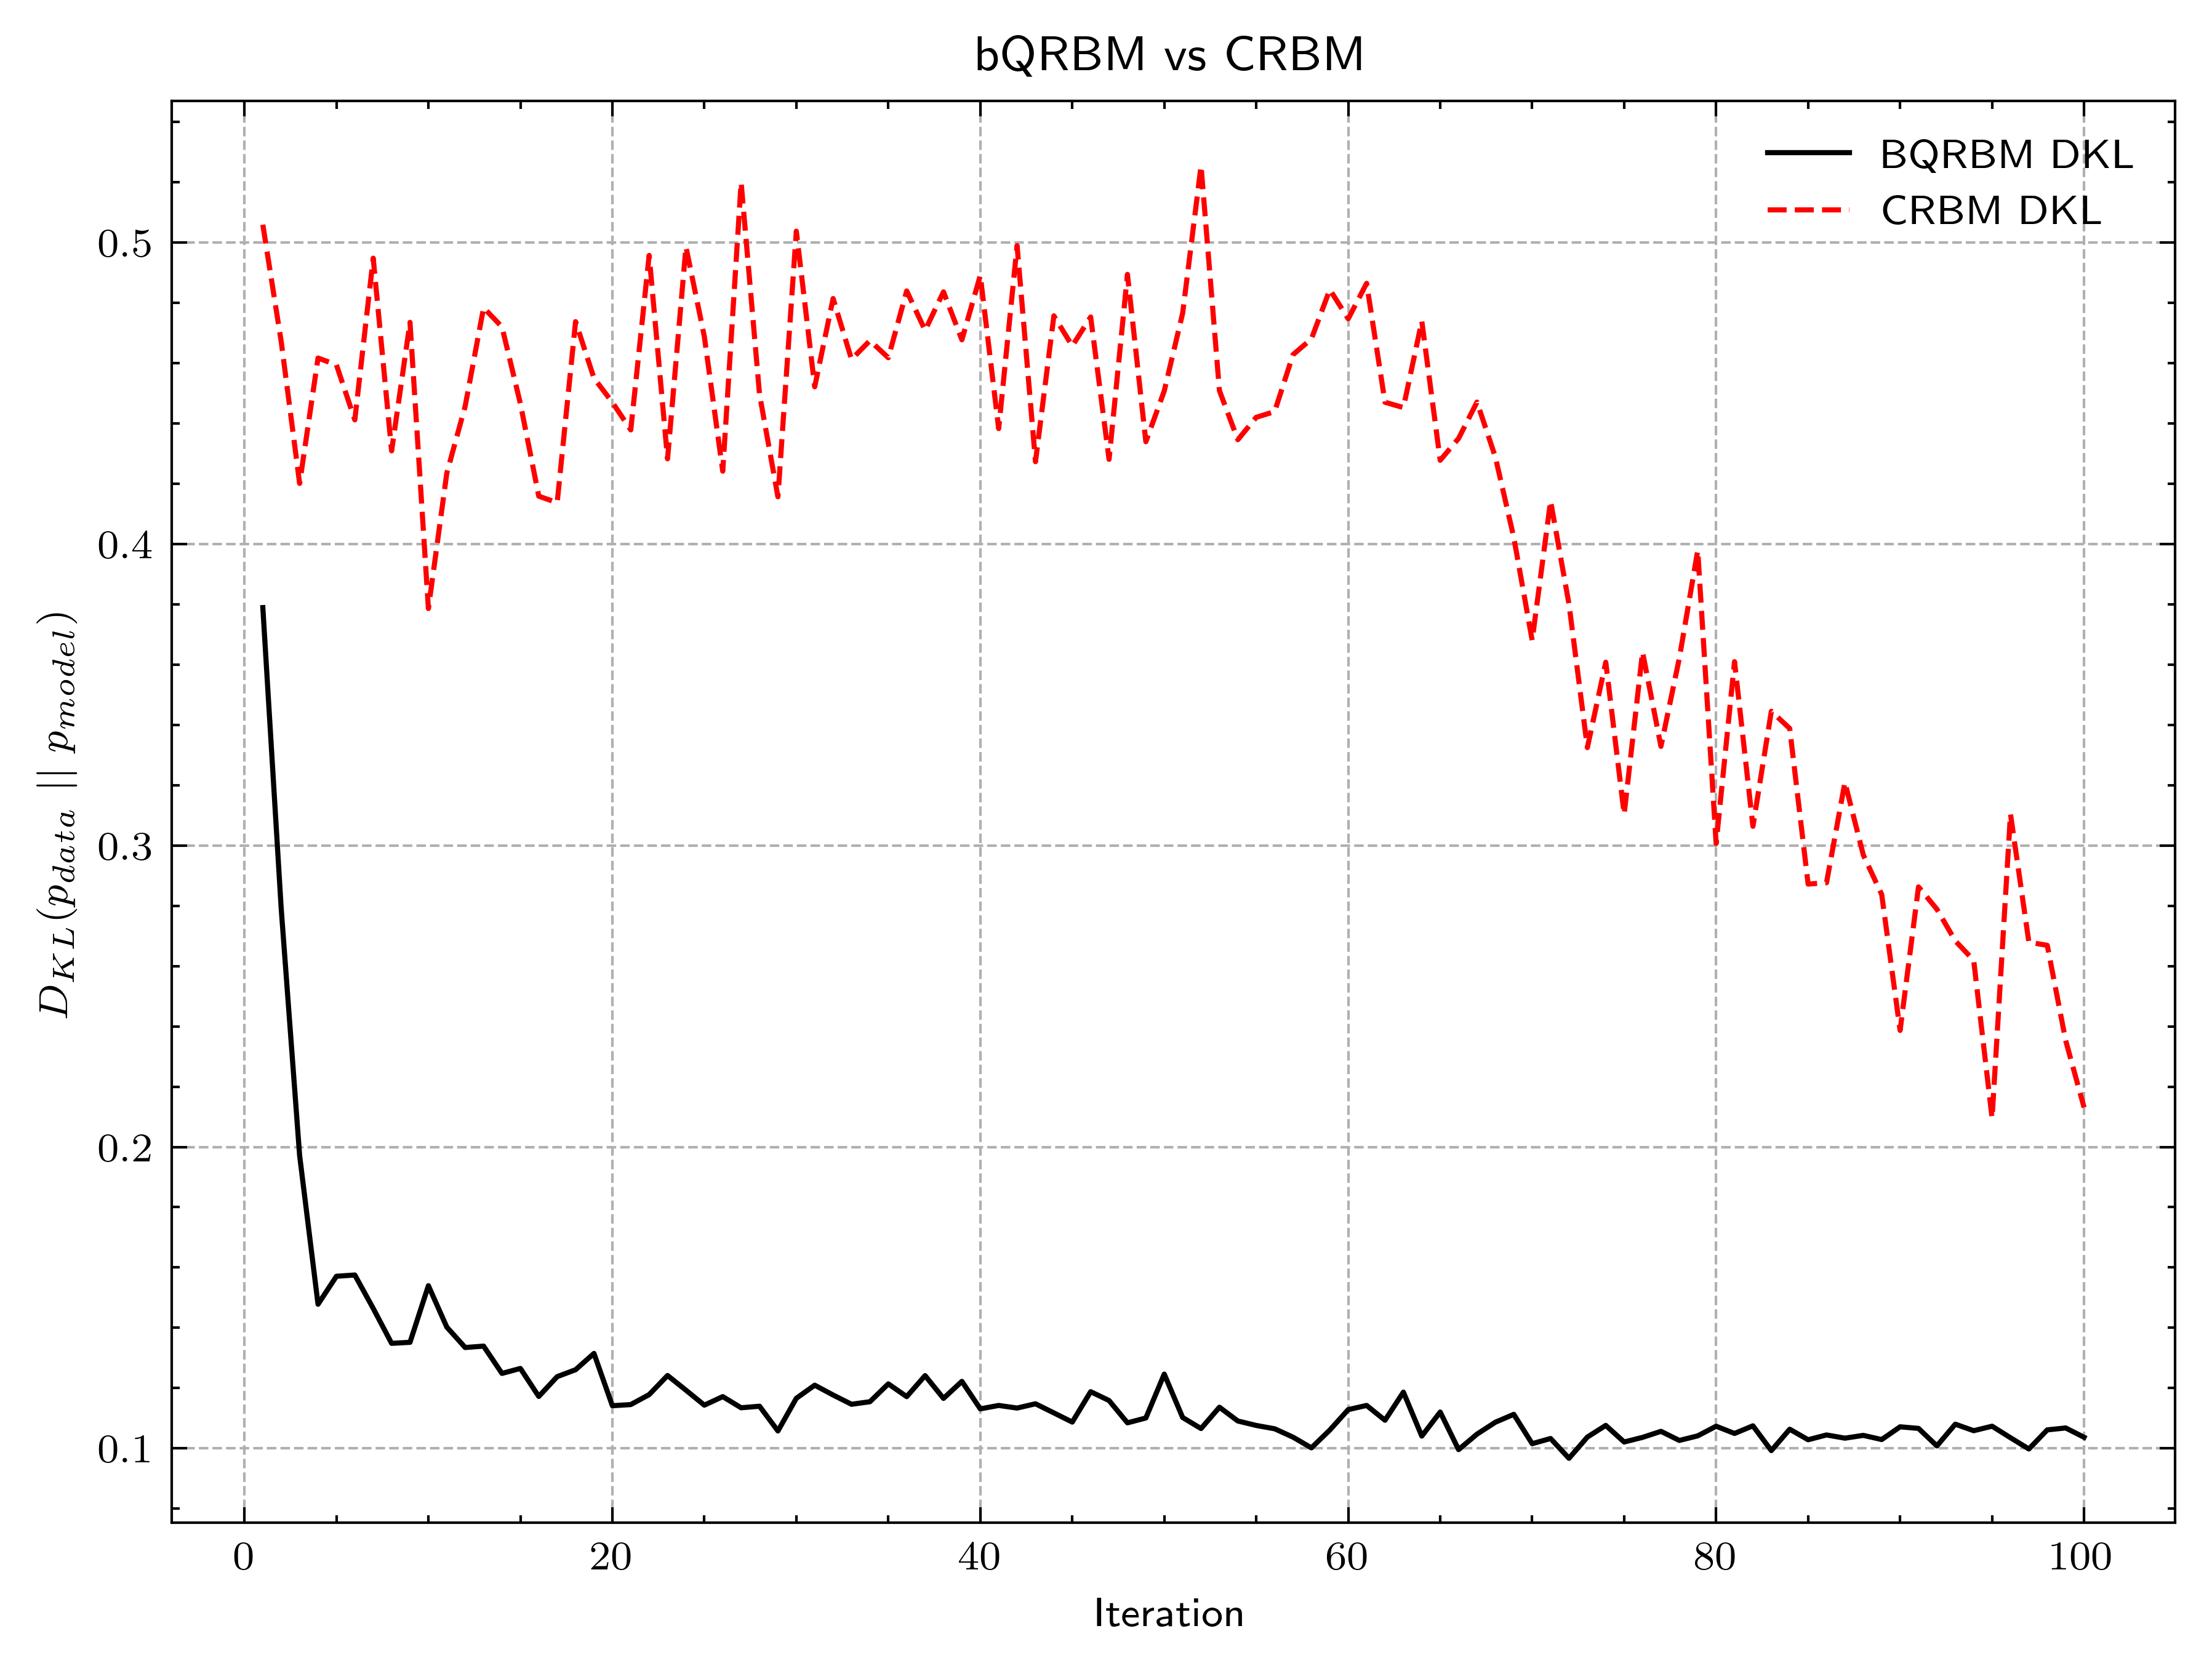

In [19]:
# Plot 1: KL Divergence Comparison

with plt.style.context(['science','ieee']):
    fig=plt.figure(figsize=(7,5)) #dpi=150
    ax=fig.add_subplot(1,1,1)
    plt.plot(bqrbm_epochs, bqrbm_dkls, label='BQRBM DKL')
    plt.plot(crbm_epochs, crbm_kl_divs_history, label='CRBM DKL')
    plt.xlabel('Iteration')
    plt.ylabel(r"$D_{KL}(p_{data} \ || \ p_{model})$")
    plt.title(" bQRBM vs CRBM ")
    plt.legend()
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    plt.savefig(compare_dir /'Dkl_CRBM_vs_bQRBM.pdf', bbox_inches='tight')
plt.show()


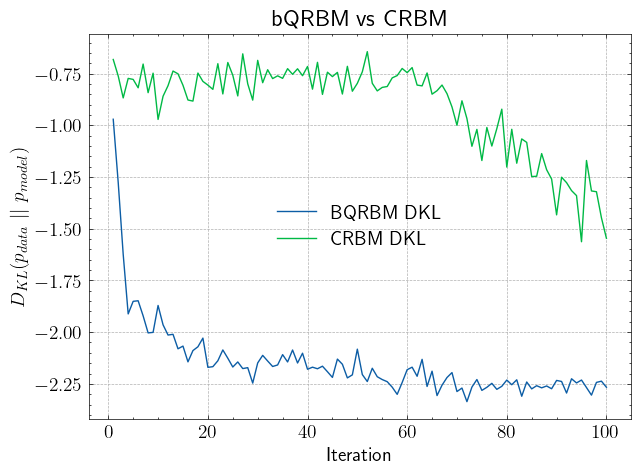

In [20]:
# Plot 1: KL Divergence Comparison, logarithm

with plt.style.context(['science']):
    fig=plt.figure(figsize=(7,5)) #dpi=150
    ax=fig.add_subplot(1,1,1)
    plt.plot(bqrbm_epochs, np.log(bqrbm_dkls), label='BQRBM DKL')
    plt.plot(crbm_epochs, np.log(crbm_kl_divs_history), label='CRBM DKL')
    plt.xlabel('Iteration')
    plt.ylabel(r"$D_{KL}(p_{data} \ || \ p_{model})$")
    plt.title(" bQRBM vs CRBM ")
    plt.legend()
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    plt.savefig(compare_dir / 'Log_dkl_CRBM_vs_bQRBM.pdf', bbox_inches='tight')
plt.show()

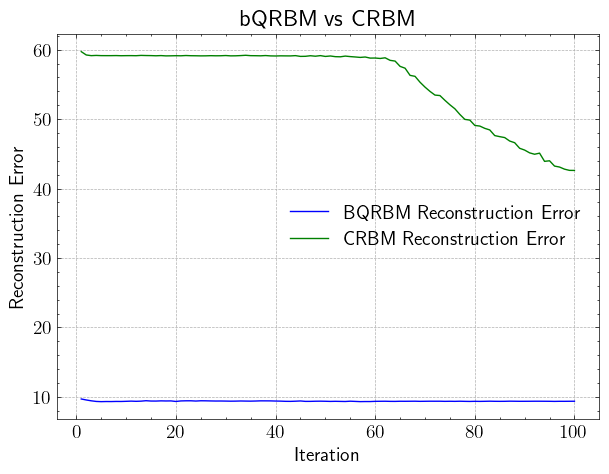

In [21]:

# Plot 2: Training Error Comparison
with plt.style.context(['science']):
    fig=plt.figure(figsize=(7,5)) #dpi=150
    ax=fig.add_subplot(1,1,1)
    plt.plot(bqrbm_epochs,bqrbm_errors , label='BQRBM Reconstruction Error', color='blue')
    plt.plot(crbm_epochs,errors , label='CRBM Reconstruction Error', color='green')
    plt.xlabel('Iteration')
    plt.ylabel(r"Reconstruction Error")
    plt.title(" bQRBM vs CRBM ")
    
    plt.legend()
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    plt.savefig(compare_dir / 'error_bQRBM_vs_CRBM.pdf', bbox_inches='tight')
plt.show()



In [22]:
avg_bqrbm_error = np.nanmean(np.array(bqrbm_errors))
avg_crbm_error = np.nanmean(np.array(crbm_errors))
print(f"Average BQRBM Reconstruction Error: {avg_bqrbm_error:.4f}")
print(f"Average CRBM Reconstruction Error: {avg_crbm_error:.4f}")

Average BQRBM Reconstruction Error: 9.3750
Average CRBM Reconstruction Error: 55.4507


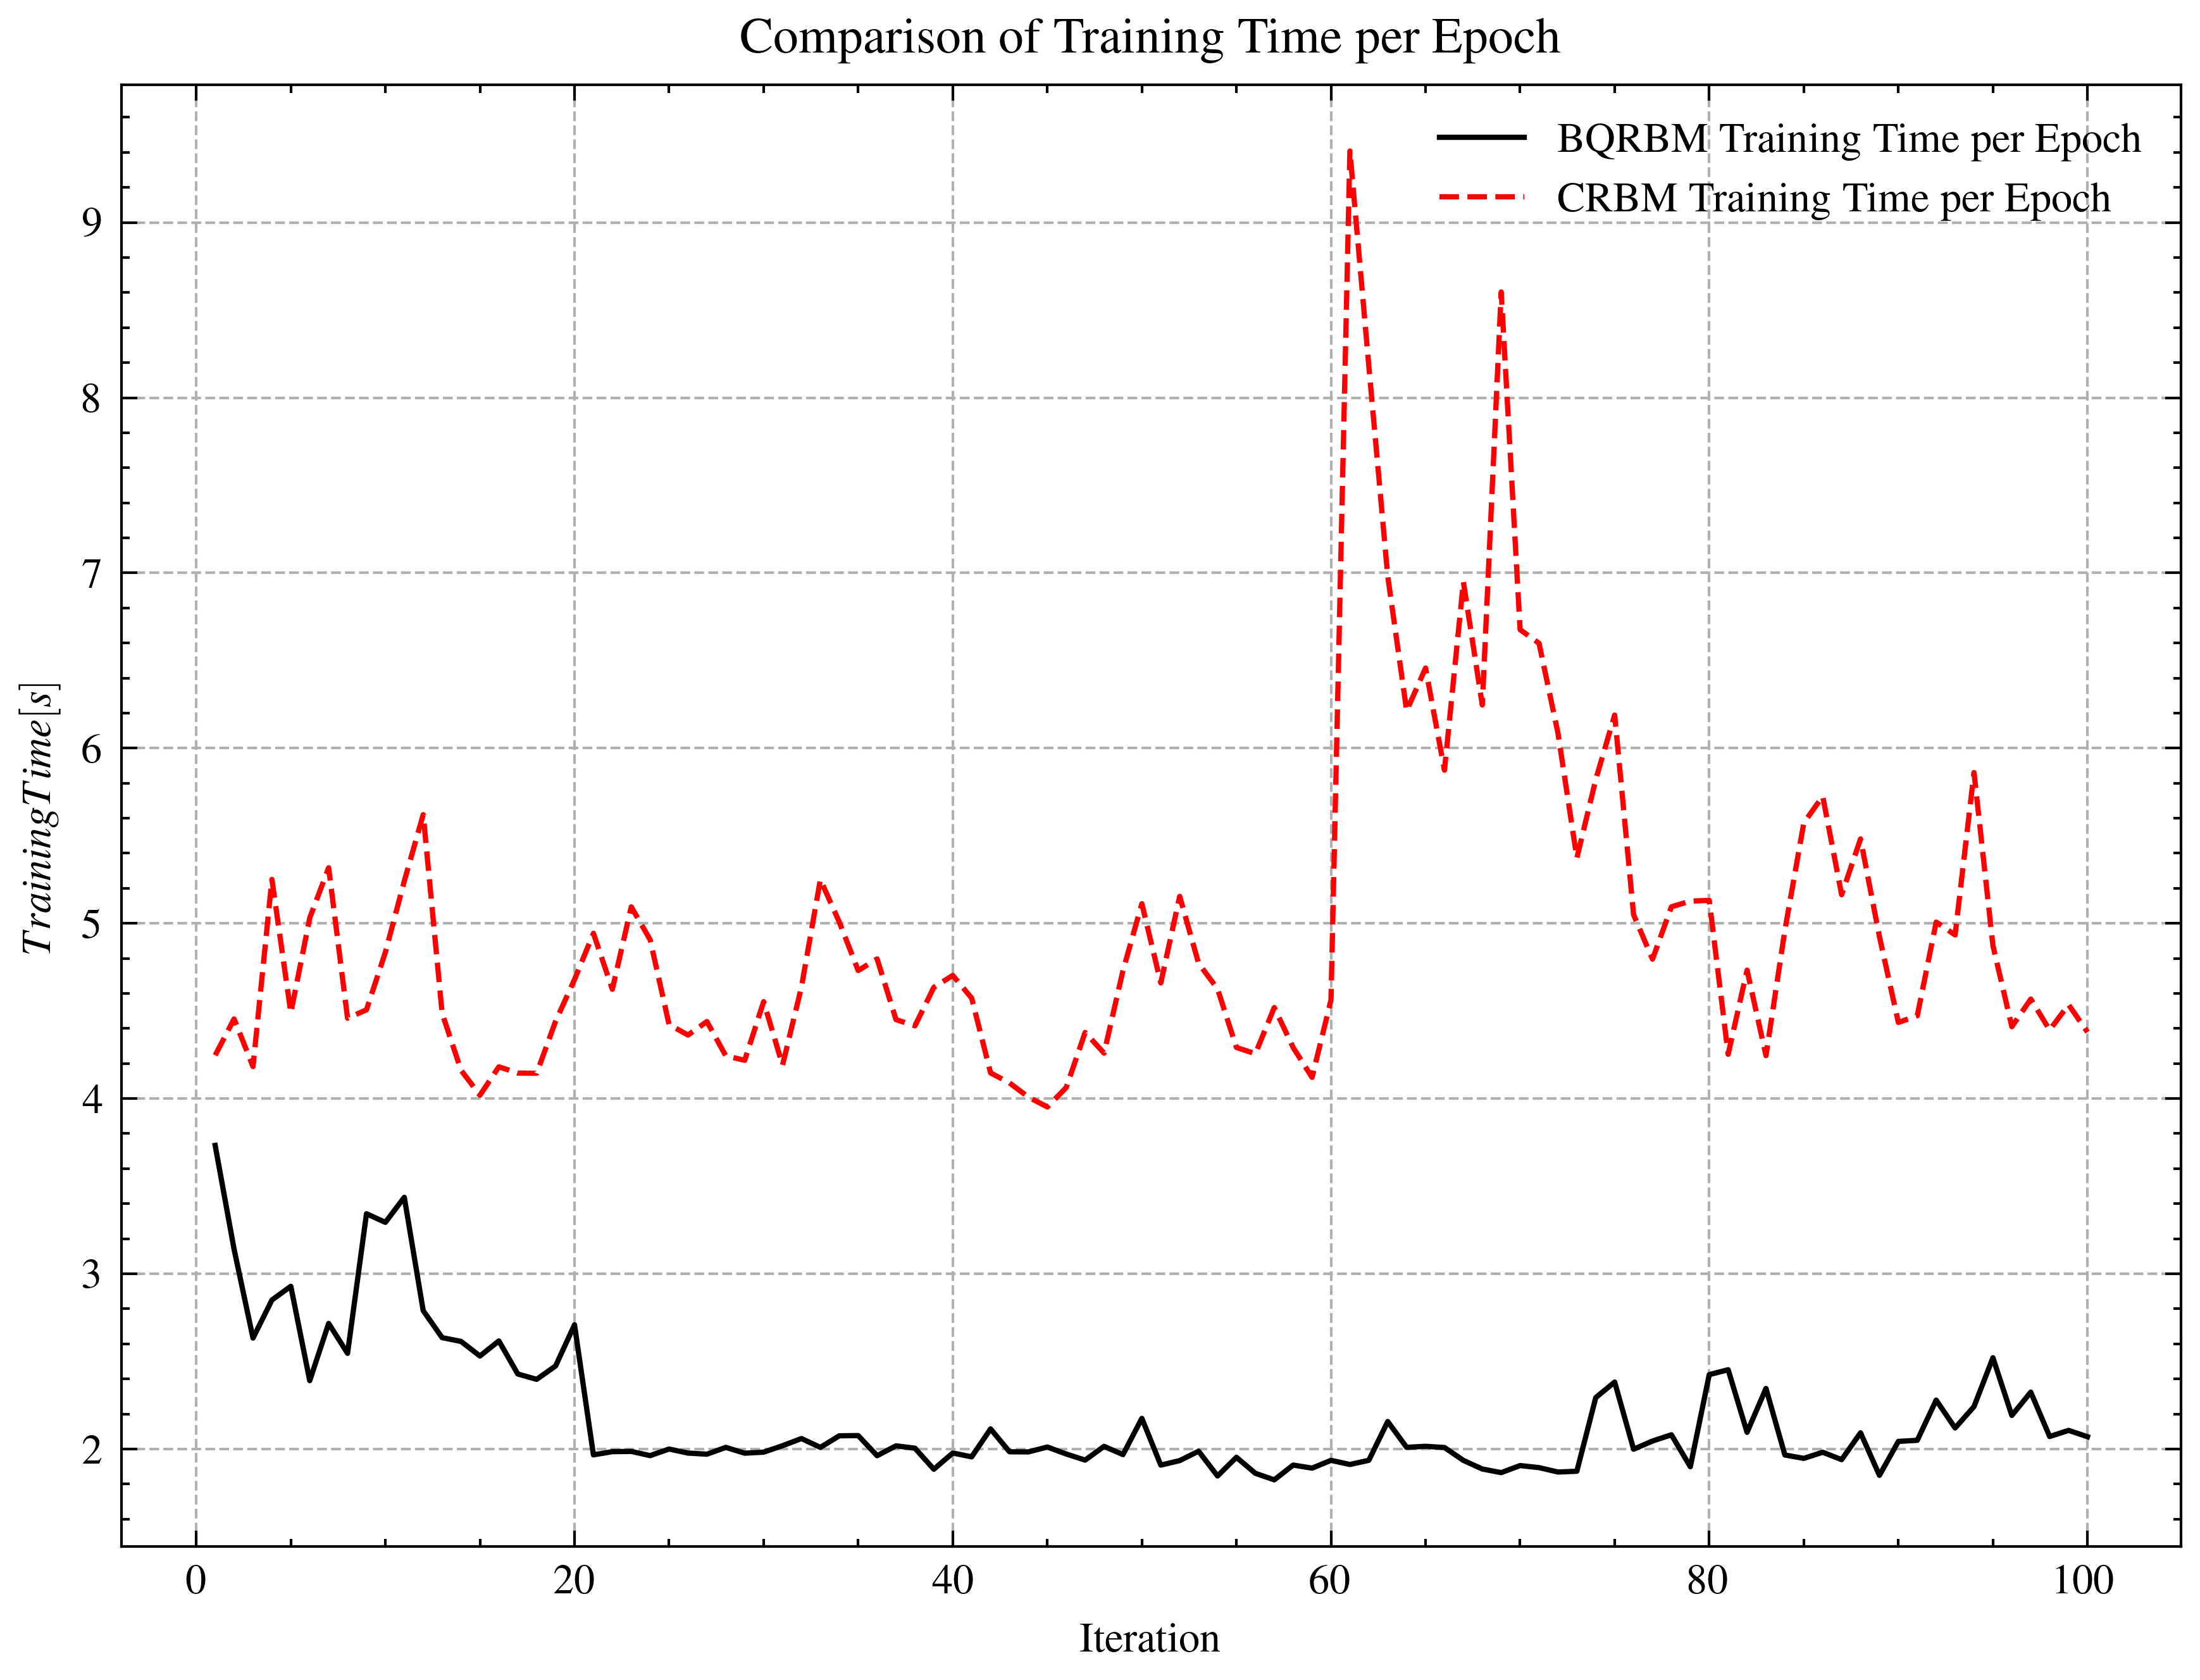

In [23]:
# Plot 3: Training Time per Epoch Comparison
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(range(1, len(bqrbm_epoch_times) + 1), bqrbm_epoch_times, label='BQRBM Training Time per Epoch')
    ax.plot(crbm_epochs, crbm_epoch_times, label='CRBM Training Time per Epoch')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('$Training Time[s]$')
    ax.set_title('Comparison of Training Time per Epoch')
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    ax.legend()
    # save pdf
    plt.savefig('training_time_bQRBM_vs_CRBM.pdf', format='pdf', bbox_inches='tight')
    plt.show()



In [24]:
avg_bqrbm_train_time = np.nanmean(np.array(bqrbm_epoch_times))
avg_crbm_train_time = np.nanmean(np.array(crbm_epoch_times))
print(f"Average BQRBM Reconstruction Error: {avg_bqrbm_train_time:.4f}")
print(f"Average CRBM Reconstruction Error: {avg_crbm_train_time:.4f}")

Average BQRBM Reconstruction Error: 2.1833
Average CRBM Reconstruction Error: 4.9686


In [25]:
print(f"Comparison plots saved in {compare_dir}")

Comparison plots saved in compare_CRBM_QRBM
